## Introduction
In any kind of business, customer segmentation is important to understand the target audience. It can change how advertisements are shown or what to focus on for different customer segments, based on their personal interests and demographic profile.

For that purpose, we can use unsupervised machine learning algorithms to identify a user base and group them in clusters based on characteristics they have in common.

This notebook shows how to do it using an unsupervised learning technique called K-Means clustering, which takes in unlabelled customer data and assigns each data point to clusters, resulting in distinct non-overlapping sub-groups.

Here's a great article on the subject: https://scikit-learn.org/stable/modules/clustering.html#k-means

This notebook will address:

- Data analysis and pre-processing for K-Means clustering
- Building a K-Means clustering algorithm
- The metrics used to evaluate the performance of a clustering model
- Different ways to visualize clusters built
- Interpretation and analysis of clusters built

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
import os

### Reading the data frame and initial analysis
Source: Kaggle's Mall Customer Segmentation Data - https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

In [3]:
df.shape

(200, 5)

In [4]:
df.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

This dataset doesn't contain any null values, so we don't need to handle that. 

### Initial analysis

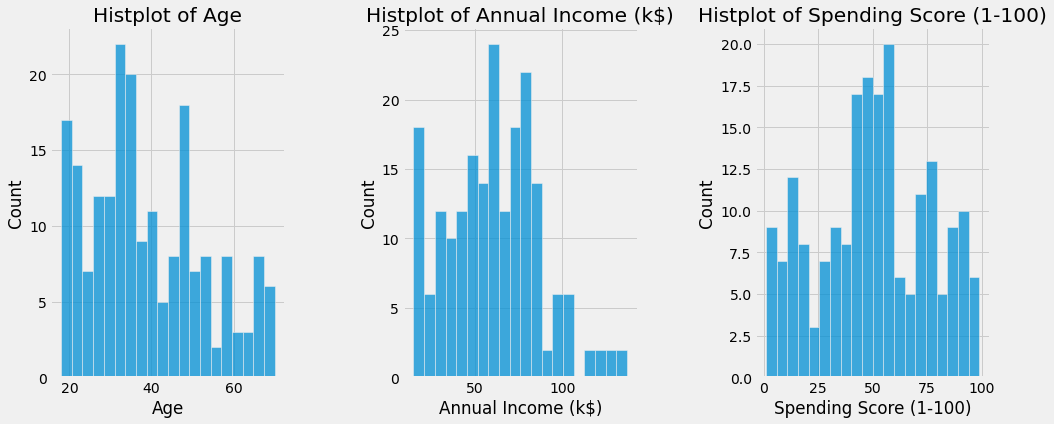

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    #sns.distplot(df[x] , bins = 20)
    sns.histplot(df[x] , bins = 20)
    plt.title('Histplot of {}'.format(x))
plt.show()

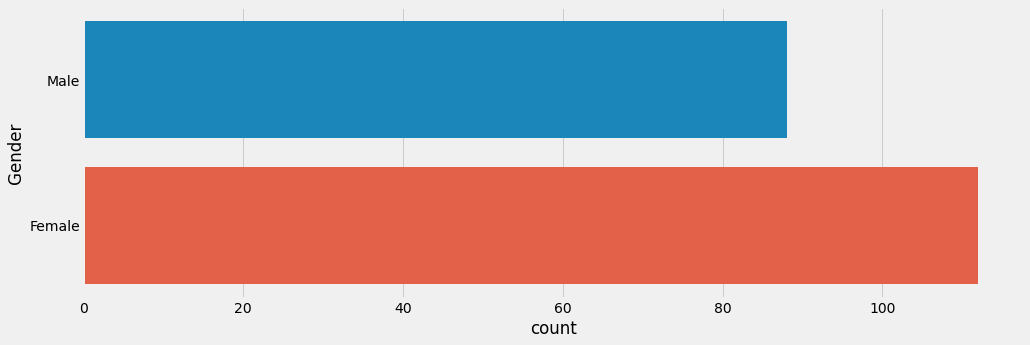

In [8]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

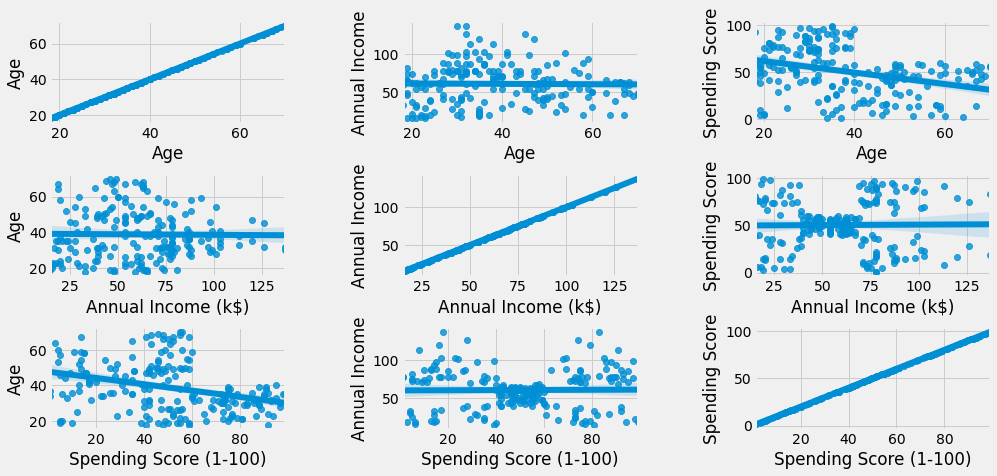

In [9]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

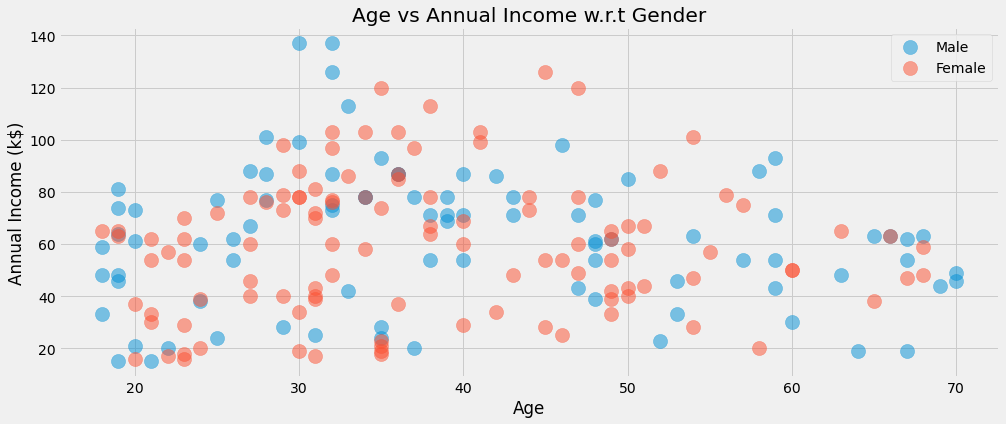

In [10]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

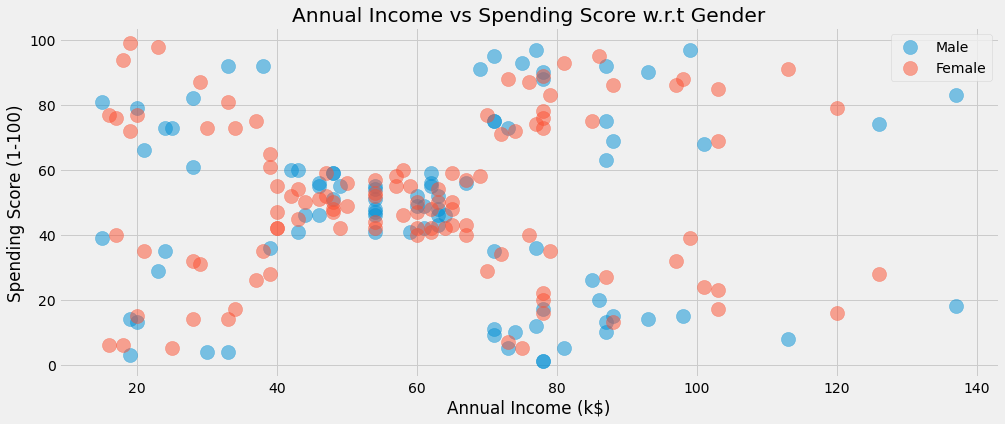

In [11]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income vs Spending Score w.r.t Gender')
plt.legend()
plt.show()

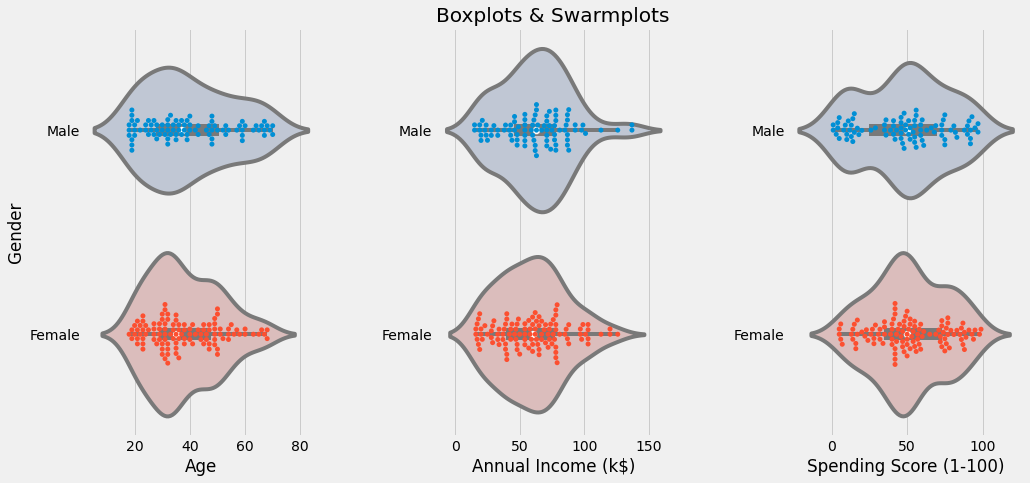

In [12]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

There are five variables in the dataset. Since CustomerID doesn't provide any useful cluster information, it can be droped.

Gender is a categorial variable, so it needs to be encoded and converted into numeric.

All other variables will be scaled to follow a normal distribution before being fed into the model. We will standardize these variables with a mean of 0 and a standard deviation of 1.

In [35]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

Annual Income (k$)       Age  Spending Score (1-100)
0           -1.738999 -1.424569               -0.434801
1           -1.738999 -1.281035                1.195704
2           -1.700830 -1.352802               -1.715913
3           -1.700830 -1.137502                1.040418
4           -1.662660 -0.563369               -0.395980

In [14]:
gender = df['Gender']
newdf = scaled_features.join(gender)

newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

newdf = newdf.drop(['Gender_Female'],axis=1)

newdf.head()

Annual Income (k$)       Age  Spending Score (1-100)  Gender_Male
0           -1.738999 -1.424569               -0.434801            1
1           -1.738999 -1.281035                1.195704            1
2           -1.700830 -1.352802               -1.715913            0
3           -1.700830 -1.137502                1.040418            0
4           -1.662660 -0.563369               -0.395980            0

### Two-dimensional analysis

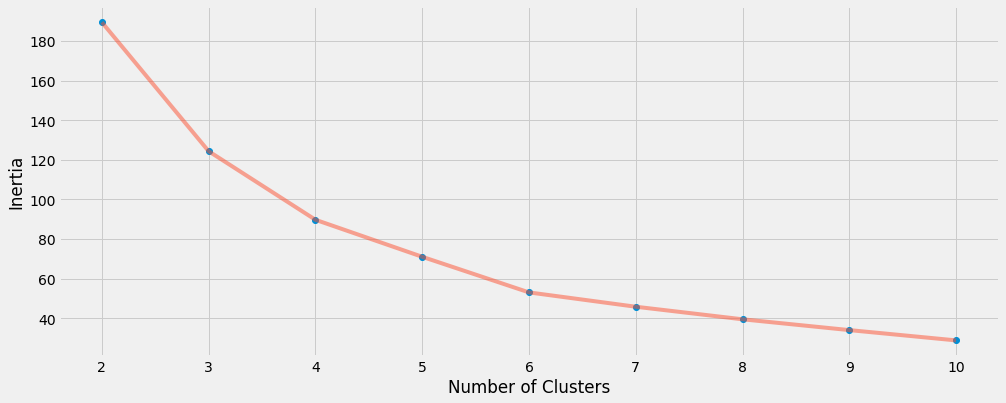

In [15]:
# Age and spending Score
X1 = newdf[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(2, 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2, 11) , inertia , 'o')
plt.plot(np.arange(2, 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

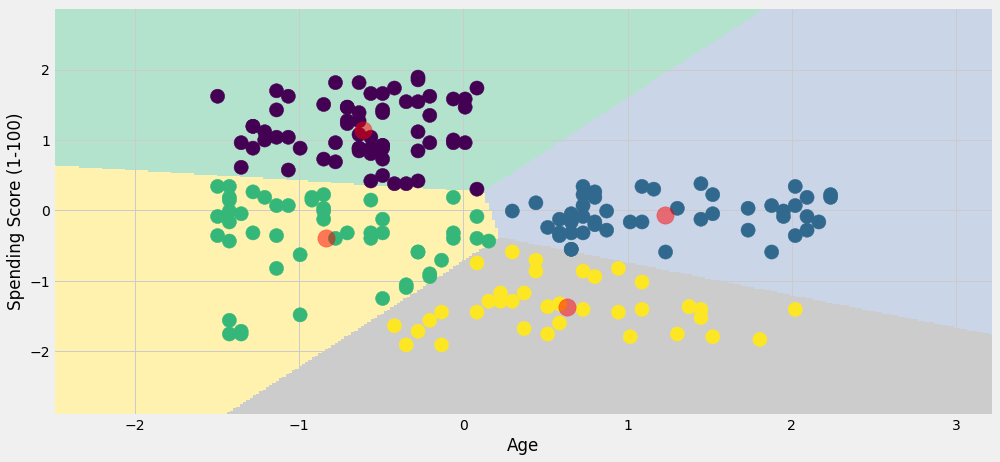

In [17]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = newdf , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

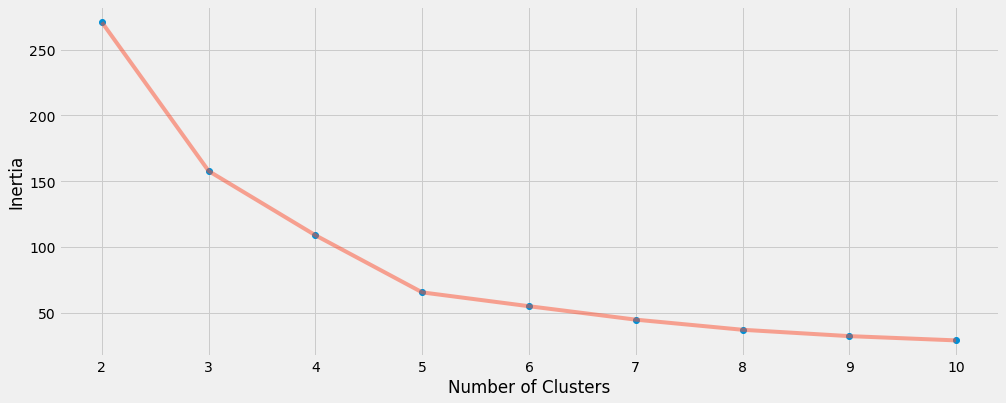

In [18]:
#Annual Income and spending Score
X2 = newdf[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(2, 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2, 11) , inertia , 'o')
plt.plot(np.arange(2, 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

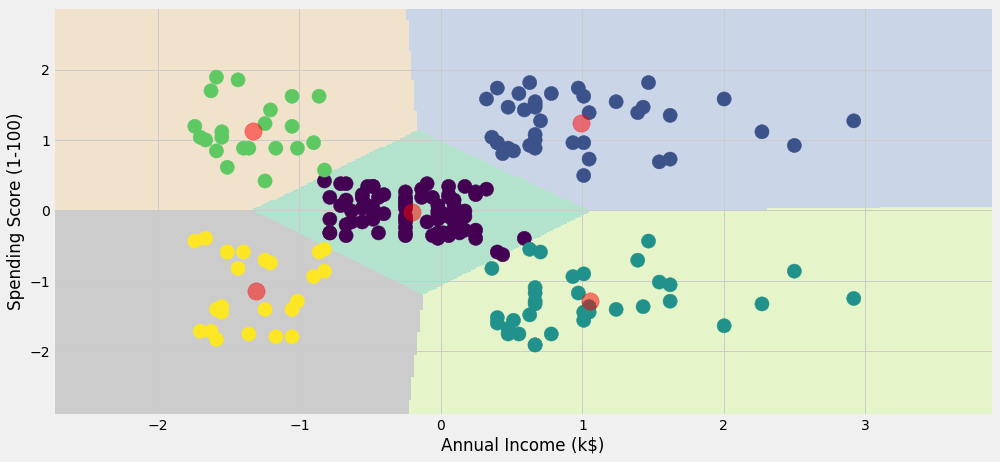

In [19]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = newdf , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

### Metrics 
- Inertia: tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for.
The range of inertia’s value starts from zero and goes up.

- Silhouette score: tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1 and the higher the score, the better.

Text(0, 0.5, 'Inertia')

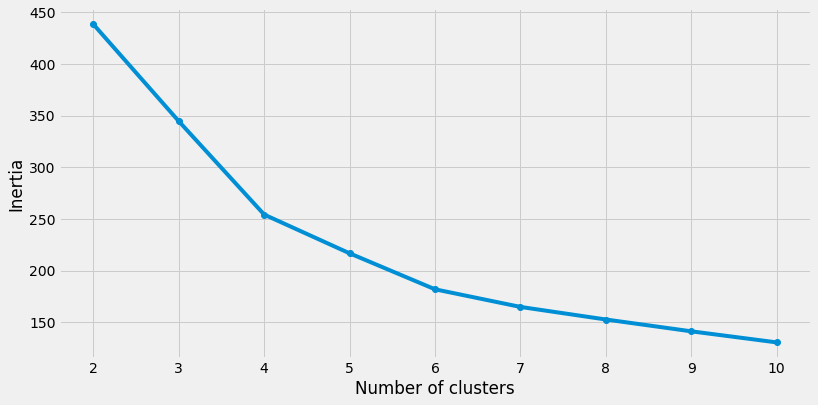

In [20]:
# Segmentation using Age , Annual Income and Spending Score
SSE = []

for cluster in range(2,11):
    kmeans = (KMeans(n_clusters = cluster ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan'))
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(2,11), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [21]:
# First, build a model with 4 clusters

algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan'))
algorithm.fit(newdf)

# Now, print the silhouette score of this model
print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.32097978270516947


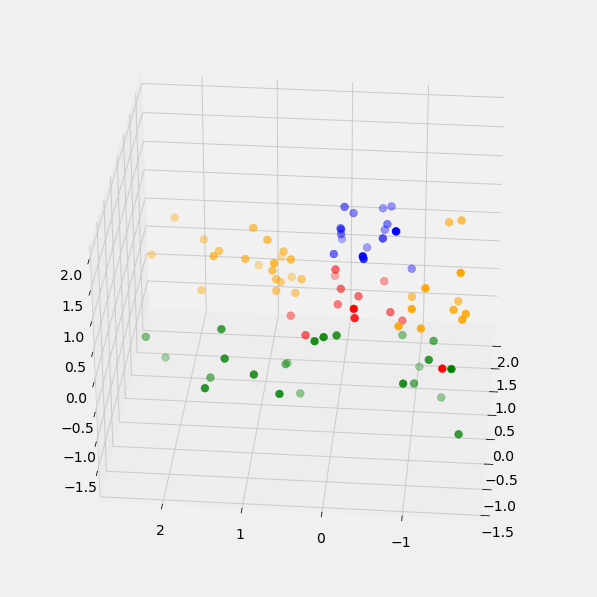

In [22]:
clusters = kmeans.fit_predict(newdf.iloc[:,1:])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf["Age"][newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue',   s=60)
ax.scatter(newdf["Age"][newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red',    s=60)
ax.scatter(newdf["Age"][newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green',  s=60)
ax.scatter(newdf["Age"][newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

In [23]:
X3 = newdf[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

newdf['label3'] =  labels3
trace1 = go.Scatter3d(
    x= newdf['Age'],
    y= newdf['Spending Score (1-100)'],
    z= newdf['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = newdf['label3'], 
        size= 20,
        line=dict(
            color= newdf['label3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Feature selection
Principal Component Analysis (PCA): a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

We can select a subset of these variables and include them into the K-means model.

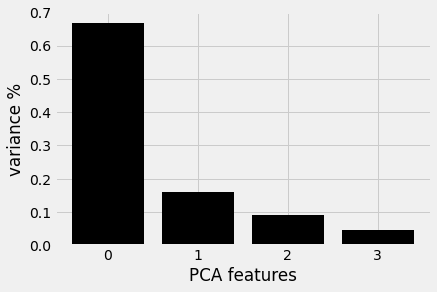

In [24]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

This chart shows each PCA component, along with it variance.

Based on this visualization, we can see that the first two PCA components explain over 70% of the dataset variance, we can feed these two components into the model.

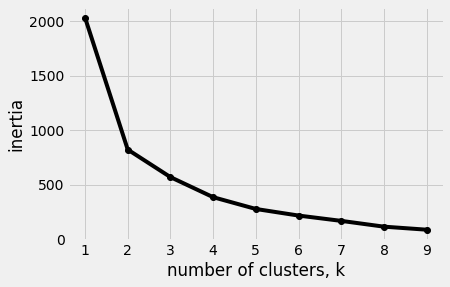

In [25]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [26]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.477940174673838


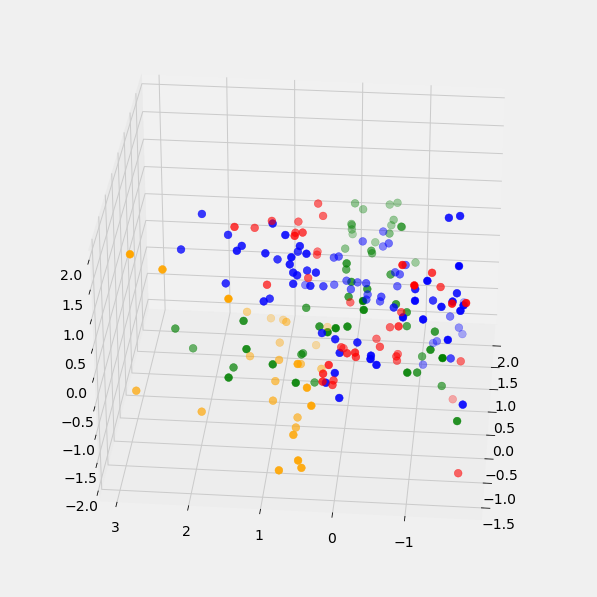

In [27]:
model = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue',   s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red',    s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green',  s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)
ax.scatter(newdf.Age[newdf.label == 4], newdf["Annual Income (k$)"][newdf.label == 4], newdf["Spending Score (1-100)"][newdf.label == 4], c='yellow', s=60)
ax.scatter(newdf.Age[newdf.label == 5], newdf["Annual Income (k$)"][newdf.label == 5], newdf["Spending Score (1-100)"][newdf.label == 5], c='purple', s=60)

ax.view_init(30, 185)
plt.show()

### Using 6 clusters instead of 4

In [28]:
X4 = newdf[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X4)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

newdf['label3'] =  labels3
trace1 = go.Scatter3d(
    x= newdf['Age'],
    y= newdf['Spending Score (1-100)'],
    z= newdf['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = newdf['label3'], 
        size= 20,
        line=dict(
            color= newdf['label3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Cluster Analysis

In [29]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = algorithm.predict(newdf[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values)
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0    Male   19                  15                      39        5
1    Male   21                  15                      81        5
2  Female   20                  16                       6        4
3  Female   23                  16                      77        5
4  Female   31                  17                      40        4

In [30]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

cluster        Age  Annual Income (k$)  Spending Score (1-100)
0        0  56.333333           54.266667               49.066667
1        1  26.684211           57.578947               47.789474
2        2  32.692308           86.538462               82.128205
3        3  41.939394           88.939394               16.969697
4        4  45.523810           26.285714               19.380952
5        5  25.250000           25.833333               76.916667

<AxesSubplot:xlabel='cluster', ylabel='Age'>

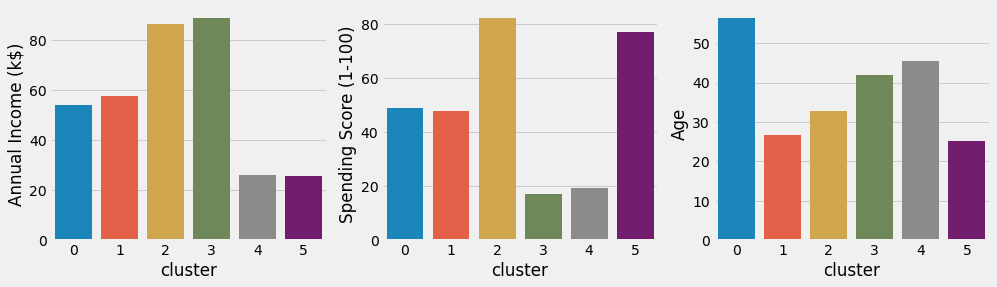

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df, ax=axs[0])
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df, ax=axs[1])
sns.barplot(x='cluster',y='Age',data=avg_df, ax=axs[2])

- Cluster 0: Medium income, medium spending, high age. Older people, probably almost retired. Spendings compatible to their income, to live a comfortable live and save for retirement.
- Cluster 1: Medium income, medium spending, medium- age. Young people with decent income and moderate spending, probably more inclined to look for sales or coupons.
- Cluster 2: High income, high spending, medium age. High earning/spending adults. Likely most of them just started a family.
- Cluster 3: High income, low spending, medium+ age. High earning adults who are very careful with their money. Probably saving up to buy a house or other sort of investment.
- Cluster 4: Low income, low spending, medium+ age. These people don't make a lot of money and have compatible spending habits, which makes sense based on their higher age. Another group that would benefit from sales or coupons.
- Cluster 5: Low income, high spending, low age. Young people who enjoy living a good lifestyle and tend to spend above their means. This should be taken into account for credit purposes.

In [32]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2

Gender
cluster Gender        
0       Female      26
        Male        19
1       Female      24
        Male        14
2       Female      21
        Male        18
3       Female      14
        Male        19
4       Female      13
        Male         8
5       Female      14
        Male        10